<a href="https://colab.research.google.com/github/MostafaEldakamawy/machine-learning-projects/blob/main/demand_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae


uploading the data set

In [2]:
data = pd.read_csv('/content/train.csv')

In [3]:
data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
data.shape

(913000, 4)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [6]:
data.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


**feature engineering**

In [7]:
parts = data['date'].str.split('-',n=3, expand=True)
data['year'] = parts[0].astype(int)
data['month'] = parts[1].astype(int)
data['day'] = parts[2].astype(int)
data.head()

,date,store,item,sales,year,month,day
0,2013-01-01,1,1,13,2013,1,1
1,2013-01-02,1,1,11,2013,1,2
2,2013-01-03,1,1,14,2013,1,3
3,2013-01-04,1,1,13,2013,1,4
4,2013-01-05,1,1,10,2013,1,5


In [8]:
from datetime import datetime
import calendar
def weekend_or_weekday(year,month,day):
  a = datetime(year,month,day)
  if a.weekday()>4:
    return 1
  else:
    return 0

data['weekend'] = data.apply(lambda x:weekend_or_weekday(x['year'],x['month'],x['day']),axis=1)
data.head()

,date,store,item,sales,year,month,day,weekend
0,2013-01-01,1,1,13,2013,1,1,0
1,2013-01-02,1,1,11,2013,1,2,0
2,2013-01-03,1,1,14,2013,1,3,0
3,2013-01-04,1,1,13,2013,1,4,0
4,2013-01-05,1,1,10,2013,1,5,1


In [12]:
from datetime import datetime
import holidays

def is_holiday(x):
    egypt_holidays = holidays.country_holidays('EG')
    if x in egypt_holidays:
        return 1
    else:
        return 0
data['holidays'] = data['date'].apply(is_holiday)
data.head()

,date,store,item,sales,year,month,day,weekend,holidays
0,2013-01-01,1,1,13,2013,1,1,0,1
1,2013-01-02,1,1,11,2013,1,2,0,0
2,2013-01-03,1,1,14,2013,1,3,0,0
3,2013-01-04,1,1,13,2013,1,4,0,0
4,2013-01-05,1,1,10,2013,1,5,1,0


In [13]:
data['m1'] = np.sin(data['month'] * (2 * np.pi / 12))
data['m2'] = np.cos(data['month'] * (2 * np.pi / 12))
data.head()

,date,store,item,sales,year,month,day,weekend,holidays,m1,m2
0,2013-01-01,1,1,13,2013,1,1,0,1,0.5,0.866025
1,2013-01-02,1,1,11,2013,1,2,0,0,0.5,0.866025
2,2013-01-03,1,1,14,2013,1,3,0,0,0.5,0.866025
3,2013-01-04,1,1,13,2013,1,4,0,0,0.5,0.866025
4,2013-01-05,1,1,10,2013,1,5,1,0,0.5,0.866025


In [14]:
def which_day(year,month,day):
  d = datetime(year,month,day)
  return d.weekday()
data['weekday'] = data.apply(lambda x:which_day(x['year'],x['month'],x['day']),axis=1)
data.head()

,date,store,item,sales,year,month,day,weekend,holidays,m1,m2,weekday
0,2013-01-01,1,1,13,2013,1,1,0,1,0.5,0.866025,1
1,2013-01-02,1,1,11,2013,1,2,0,0,0.5,0.866025,2
2,2013-01-03,1,1,14,2013,1,3,0,0,0.5,0.866025,3
3,2013-01-04,1,1,13,2013,1,4,0,0,0.5,0.866025,4
4,2013-01-05,1,1,10,2013,1,5,1,0,0.5,0.866025,5


In [15]:
data.drop('date',axis=1,inplace=True)
data.head()

,store,item,sales,year,month,day,weekend,holidays,m1,m2,weekday
0,1,1,13,2013,1,1,0,1,0.5,0.866025,1
1,1,1,11,2013,1,2,0,0,0.5,0.866025,2
2,1,1,14,2013,1,3,0,0,0.5,0.866025,3
3,1,1,13,2013,1,4,0,0,0.5,0.866025,4
4,1,1,10,2013,1,5,1,0,0.5,0.866025,5


In [22]:
data['store'].nunique() , data['item'].nunique()

(10, 50)

**data analysis**

<ipython-input-31-3535eea09c90>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3, i + 1)


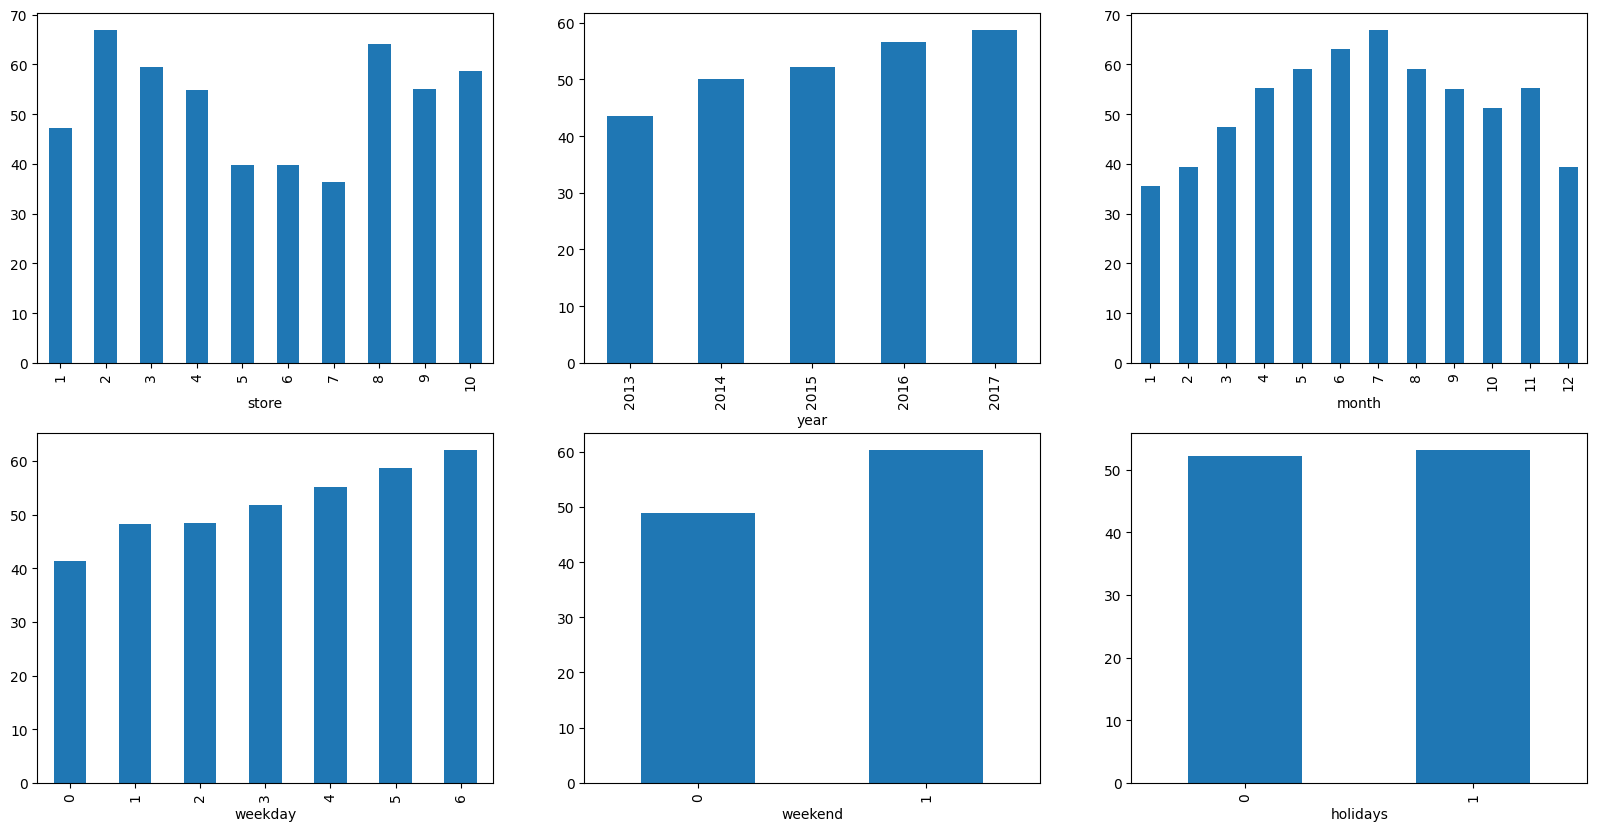

In [31]:
features = ['store','year','month','weekday','weekend','holidays']
plt.subplots(figsize=(20,10))
for i,col in  enumerate(features):
   plt.subplot(2,3, i + 1)
   data.groupby(col).mean()['sales'].plot.bar()
plt.show()

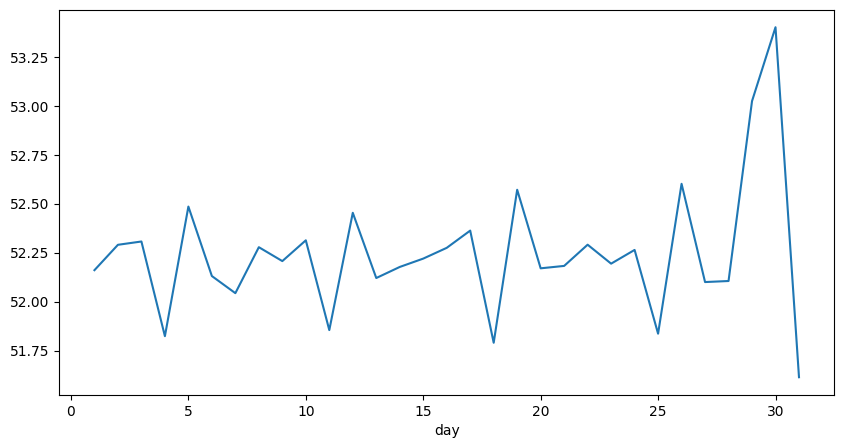

In [34]:
plt.figure(figsize=(10,5))
data.groupby('day').mean()['sales'].plot()
plt.show()

<ipython-input-39-c2537cea41f8>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)
<ipython-input-39-c2537cea41f8>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['sales'])


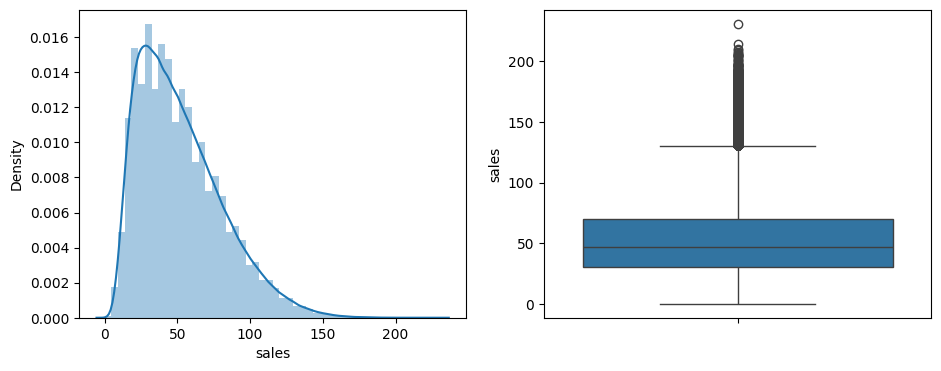

In [39]:
plt.subplots(figsize=(11,4))
plt.subplot(1,2,1)
sns.distplot(data['sales'])

plt.subplot(1,2,2)
sns.boxplot(data['sales'])
plt.show()

removing outliers

<ipython-input-41-1d2111105b6f>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)
<ipython-input-41-1d2111105b6f>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['sales'])


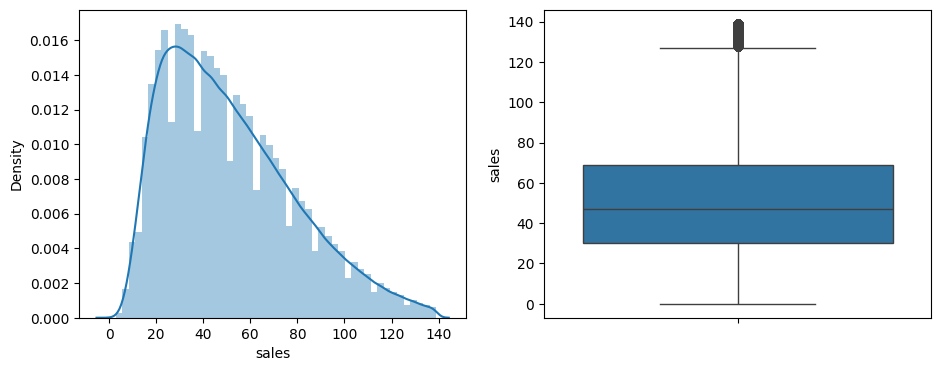

In [41]:
data = data[data['sales']<140]
plt.subplots(figsize=(11,4))
plt.subplot(1,2,1)
sns.distplot(data['sales'])

plt.subplot(1,2,2)
sns.boxplot(data['sales'])
plt.show()

splitting data

In [46]:
features = data.drop(['sales','year'],axis=1)
targets = data['sales']

X_train,X_test,Y_train,Y_test = train_test_split(features , targets , test_size=0.05 ,random_state=22)


In [47]:
X_train.shape, X_test.shape


((861170, 9), (45325, 9))

normalizing the dataset

In [53]:
# Normalizing the features for stable and fast training.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


training the models and choose the best one out of them

In [57]:
models = [LinearRegression(), XGBRegressor(), Lasso(), Ridge(), RandomForestRegressor()]

for i in range(5):
	models[i].fit(X_train, Y_train)

	print(f'{models[i]} : ')

	train_preds = models[i].predict(X_train)
	print('Training Error : ', mae(Y_train, train_preds))

	val_preds = models[i].predict(X_test)
	print('Validation Error : ', mae(Y_test, val_preds))
	print()


LinearRegression() : 
Training Error :  20.90297269011033
Validation Error :  20.971754515038015

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) : 
Training Error :  6.8884374077318276
Validation Error :  6.904444138994548

Lasso() : 
Training Error :  21.015028699769758
Validation Error :  21.07151

another way using cross validation

In [58]:
from sklearn.model_selection import cross_val_score

In [76]:
models = [LinearRegression(), XGBRegressor(), Lasso(), Ridge()]

def compare_model_cross_validation():

  for model in models:
    cv_score = cross_val_score(model, features , targets , cv=5, scoring='neg_mean_absolute_error')
    cv_score_positive = -cv_score
    mean_acc = (sum(cv_score_positive)/len(cv_score))
    print('errors of the cross validation of ',model,'=',cv_score_positive)
    print('Error of the ',model,'=',mean_acc)
    print('-------------------------------------------')
    print()



In [77]:
compare_model_cross_validation()

errors of the cross validation of  LinearRegression() = [25.8871783  22.26274484 21.74204805 20.02930821 21.71618894]
Error of the  LinearRegression() = 22.32749366898123
-------------------------------------------

errors of the cross validation of  XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) = 

In [78]:
data.to_csv('output.csv', index=False)

In [79]:
from google.colab import files

files.download('output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>